In [1]:
import underworld as uw
#uw.matplotlib_inline()
from matplotlib.figure import Figure
import matplotlib.pyplot as pyplot
import numpy as np
import math
#import glucifer
import mpi4py
comm = mpi4py.MPI.COMM_WORLD
import h5py
import glob
import UWGeodynamics as GEO
from MechanicalProperties import PlateProperties
from pathlib import Path
#from functions import PDP, KDEp, loadData,peakdet
import sys
from matplotlib.ticker import ScalarFormatter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.offsetbox import AnchoredText

loaded rc file /opt/venv/lib/python3.7/site-packages/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry
#Directories Structure - Customizable for each Modelling
dataDic={"OP_coords":"/OPTracers-*",
             "SP_coords":"/SPTracers-*",
             "Arc_coords":"/ArcTracers-*",
             "Craton_coords":"/CratonTracers-*",
             "SP_velocity":["/SPTracers_Subducting plate velocity_X-*","/SPTracers_Subducting plate velocity_Y-*"],
             "OP_velocity":["/OPTracers_Weak overriding plate velocity_X-*","/OPTracers_Weak overriding plate velocity_Y-*"],
             "Arc_velocity":["/ArcTracers_Arc nodes velocity_X-*","/ArcTracers_Arc nodes velocity_Y-*"],
             "Craton_velocity":["/CratonTracers_Cratonic overriding plate velocity_X-*","/CratonTracers_Cratonic overriding plate velocity_Y-*"],
             "OP_strainRate":"/OPTracers_Weak overriding plate strain rate-*",
             "Arc_stressTensor":["/ArcTracers_Arc stress tensor_X-*","/ArcTracers_Arc stress tensor_Y-*","/ArcTracers_Arc stress tensor_XY-*"],
             "OP_stressTensor":["/OPTracers_Weak overriding plate stress tensor_X-*","/OPTracers_Weak overriding plate stress tensor_Y-*","/OPTracers_Weak overriding plate stress tensor_XY-*"],
             "OP_stressField":["OPTracers_Weak overriding plate stress Field-*"],
             "OP_velocity":["/OPTracers_Weak overriding plate velocity_X-*","/SPTracers_Subducting plate velocity_Y-*"],
             "TimeOP":"/OPTracers_Time_OP-*",
             "TimeSP":"/SPTracers_Time_SP-*",
             "TimeArc":"/ArcTracers_Time_Arc-*",
             "TimeCrat":"/CratonTracers_Time_SP-*",
             "OP_global":"/OPTracers_global_index-*",
             "SP_global":"/SPTracers_global_index-*",
             "time":"/projTimeField-*",
            }

#Fields Keys- Viscosity, density
#Directories Structure - Customizable for each Modelling
dataDicPlots={"Density":"/projDensityField-*",
             "Material_field":"/projMaterialField-*",
             "Stress_field":"/projStressField-*",
             "Plastic_strain":"/projPlasticStrain-*",
             "Viscosity":"/projViscosityField-*",
             "Strain_rate":"/strainRateField-*",
             "Stress_tensor":"/projStressTensor-*",
              "velocity":"/velocityField-*",
             "time":"/projTimeField-*",
            }
seed1="/home/jovyan/user_data/outputs_MechanicalTransference_BenchmarkFinal_"
seed2="kmArc_80Ma_DruckerPrager_WLM"


In [3]:
dimensions = ([-1800.,-800.],[1800.,0.])
outres = (1500,300) #Output image resolution
xRes,yRes = 296,160 #Grid/mesh resolution
seed1="/home/jovyan/user_data/outputs_MechanicalTransference_BenchmarkFinal_"
seed2="kmArc_80Ma_DruckerPrager_WLM"

In [4]:
import underworld as uw
#Default Model object and mesh variable for recycling
dim=3
#Model Dimensions
Model = GEO.Model(elementRes=(296,160), #196,160 #296,128, #120,64
                  minCoord=(dimensions[0][0] * u.kilometer,dimensions[0][1] * u.kilometer), 
                  maxCoord=(dimensions[1][0] * u.kilometer,dimensions[1][1] * u.kilometer),
                  gravity=(0.0, -9.81 * u.meter / u.second**2))


In [5]:
#Colors
def getColoursfromMap(cmapKey,NumColours):
    cmap = plt.get_cmap(cmapKey)
    norm = mcolors.Normalize(vmin=1.5, vmax=NumColours)
    #Base array to calculate the colors
    seedColors=np.arange(0,NumColours,1) #Here is the start color
    colours=cmap(norm(seedColors))
    return colours

def genStdColorArray(Thicknesses,colors,colorflip):
    iColor=0
    limitThick=colorflip[1]
    plotCounter=0
    #Get Colors and put them into an array
    ColorsS=[]
    colorC=0
    for j in colors:
        ColorsS.append(getColoursfromMap(colors[colorC],len(Thicknesses)))
        colorC=colorC+1
    counter=0
    #array which will contain colors to return    
    FinalColours=[]
    
    for i in Thicknesses:
        #Color changes
        if colorflip[0]==True:
            if limitThick> i:
                Colors=ColorsS[0]
            elif limitThick<=i:
                Colors=ColorsS[1]    
            else:
                Colors=ColorsS[0]     
        color=Colors[counter]
        FinalColours.append(color)
        counter=counter+1
    return FinalColours

In [6]:
#This Will be used to calaculate lithospheric extension

def getTracerOPPosition_All(Cord,time_in_Ma,Num_of_layers,num_of_Tracers,what_layer,tracerIndex):
    Cord=Cord[0]
    layersC=getTracersfromLayer(num_of_Tracers,Num_of_layers)
    #x_coord=[]
    what_layer=int(what_layer)
    what_layer=what_layer-1
    start=layersC[what_layer][0]
    end=layersC[what_layer][1]
    X_coords=[]
    #stress=[]
    #print (start,end)
    counter=0
    for i in range (start,end+1):
        X_coords.append(Cord[transToTimeStep(time_in_Ma,0.5)][i][0])
        counter=counter+1
    X_coord=X_coords[tracerIndex-1]
    #stress.append(OPstressX_or_Y[transToTimeStep(time_in_Ma,0.5)][tracerIndex])    
    return X_coords,X_coord, time_in_Ma

def getTracerPosition(Cord,time_in_Ma,Num_of_layers,num_of_Tracers,what_layer,tracerIndex):
    #Cord=Cord[0]
    layersC=getTracersfromLayer(num_of_Tracers,Num_of_layers)
    #x_coord=[]
    what_layer=int(what_layer)
    what_layer=what_layer-1
    start=layersC[what_layer][0]
    end=layersC[what_layer][1]
    X_coord=(Cord[transToTimeStep(time_in_Ma,0.5)][0])
    #stress.append(OPstressX_or_Y[transToTimeStep(time_in_Ma,0.5)][tracerIndex])    
    return X_coord, time_in_Ma

import underworld.function as fn
def VelMeshfromFile(seed1,seed2,Model,thickness,time_Ma):
    timeStep=transToTimeStep(time_Ma,0.5)
    #Dir with data
    dirr=seed1+str(thickness)+seed2
    #Auxiliar mesh variable
    varVel=Model.add_mesh_variable("Vel_Field", nodeDofCount=2)
    Data_var_dir,fn=getData(seed1,seed2,"velocity",time_Ma,thickness,dataDicPlots)
    #Data_var_dir=getVariableDataFn("velocity",dirr,dataDicPlots)[0]
    data=Data_var_dir
    #Assign to temp variable data from File
    varVel.data[:]=data
    return varVel

def StressTensorMeshfromFile(seed1,seed2,Model,thickness,time_Ma):
    timeStep=transToTimeStep(time_Ma,0.5)
    #Dir with data
    dirr=seed1+str(thickness)+seed2
    #Auxiliar mesh variable
    tensorStress=Model.add_mesh_variable("Stress tensor", nodeDofCount=2)
    Data_var_dir,fn=getData(seed1,seed2,"Stress_tensor",time_Ma,thickness,dataDicPlots)
    #Data_var_dir=getVariableDataFn("velocity",dirr,dataDicPlots)[0]
    data=Data_var_dir
    #Assign to temp variable data from File
    tensorStress.data[:]=data
    return tensorStress


def getMeshfromFile(seed1,seed2,Model,thickness,time_Ma,FieldKey,dimension):
    timeStep=transToTimeStep(time_Ma,0.5)
    #Dir with data
    dirr=seed1+str(thickness)+seed2
    #Auxiliar mesh variable
    MeshVar=Model.add_mesh_variable("Mesh_Variable", nodeDofCount=dimension)
    Data_var,fn=getData(seed1,seed2,FieldKey,time_Ma,thickness,dataDicPlots)
    #Data_var_dir=getVariableDataFn("velocity",dirr,dataDicPlots)[0]
    data=Data_var
    #Assign to temp variable data from File
    MeshVar.data[:]=data
    return MeshVar


def getSubMeshfromFile(seed1,seed2,Model,thickness,time_Ma,FieldKey,dimension):
    timeStep=transToTimeStep(time_Ma,0.5)
    #Dir with data
    dirr=seed1+str(thickness)+seed2
    #Auxiliar mesh variable
    subMeshVar=Model.add_submesh_field("Mesh_Variable", nodeDofCount=dimension)
    Data_var,fn=getData(seed1,seed2,FieldKey,time_Ma,thickness,dataDicPlots)
    #Data_var_dir=getVariableDataFn("velocity",dirr,dataDicPlots)[0]
    data=Data_var
    #Assign to temp variable data from File
    subMeshVar.data[:]=data
    return subMeshVar

    
def getVariableDataFn(filter_variable,directorySeed,dataDic):
    Data=[]
    #Get File seed for getting data from specified kind of data from dictionary key
    Dirs_with_data=GetVariableDirectoryFn(filter_variable,directorySeed,dataDic)
#     print((Dirs_with_data[0]))
#     print(len(Dirs_with_data[0]))
#     print(type(Dirs_with_data[0][0]))
    if len(Dirs_with_data[0])>3:
        folderName=directorySeed
        DataDir=["/"+folderName+"/"]
        #print(DataDir)
        Data.append(GetTracerData(DataDir,Dirs_with_data[0])) 
    else:
        #Get fixed directories to read .h5 files
        for i in Dirs_with_data[0]:
            folderName=directorySeed
            DataDir=["/"+folderName+"/"]
            Data.append(GetTracerData(DataDir,i)) 
    return Data

def getCoordsfromMesh(seed1,seed2,Model,thickness,time_Ma):
    timeStep=transToTimeStep(time_Ma,0.5)
    #Dir with data
    dirr=seed1+str(thickness)+seed2
    #Get coordinates from UW Mesh
    Coords=Model.mesh.data
    #Auxiliar mesh variable
    varTime=Model.add_mesh_variable("Time", nodeDofCount=1)
    Data_var_dir,fn=getData(seed1,seed2,"time",time_Ma,thickness,dataDicPlots)
    #Data_var_dir=getVariableDataFn("velocity",dirr,dataDicPlots)[0]
    data=Data_var_dir
    varTime.data[:]=data
    return Coords,varTime.data

def getTracerPosition(Cord,tracerIndex):
    #Cord=Cord[0]
    X_coord=(Cord[tracerIndex])
    #stress.append(OPstressX_or_Y[transToTimeStep(time_in_Ma,0.5)][tracerIndex])    
    return X_coord

def get_tracerXCoordCrustalSample(seed1,seed2,thickness,time_in_Ma,tracerKey,X_deltaTracer,dataDic):
    #Coord and X-coord for specified time, crustal domain and tracer id
    if tracerKey=="Arc_crust":
        ACoord,fn=getData(seed1,seed2,"Arc_coords",time_in_Ma,thickness,dataDic)
        Coord=getTracerPosition(ACoord,100)[0] #Middle of intra-oceanic arc - 0 Ma
    elif tracerKey=="OP_crust":
        OPCoord,fn=getData(seed1,seed2,"OP_coords",time_in_Ma,thickness,dataDic)
        Coord=getTracerPosition(OPCoord,200)[0] #Middle of OP plate - 0 Ma
    elif tracerKey=="SP_crust":
        SPCoord,fn=getData(seed1,seed2,"SP_coords",time_in_Ma,thickness,dataDic)
        Coord=getTracerPosition(SPCoord,150)[0] #Middle of OP plate - 0 Ma
    elif tracerKey=="Collisional_zone":    
        ACoord,fn=getData(seed1,seed2,"Arc_coords",time_in_Ma,thickness,dataDic)
        Coord=getTracerPosition(ACoord,200)[0] #Trech-tracer
        
    Coord=Coord+X_deltaTracer
    return Coord

In [38]:
def extractFromPosition(string,position):
    index=''
    for i in range(position,len(string)):
        if string[i].isdigit()==True:
            index=index+string[i]
    return index[:-1]
    
def getIndexFromFileCustom(filePath):
    counter=0
    detector=0
    for i in filePath:
        if i=='-':
            if detector>0:
                index=float(extractFromPosition(filePath,counter))
                break
            detector=detector+1
        counter=counter+1
    return index

    return Dirs

def GetVariableDirectoryFn(filter_variable,directorySeed,dataDic):
    Dirs_data=[]
    folderName=directorySeed
    modelDir=["/"+folderName+"/"]
    for key,val in dataDic.items():
        if key==filter_variable:
            aux=dataDic[key]
            break
    Dirs_data.append(aux)
    return Dirs_data

def GetVariableDirectoryFnCustom(fileSeed,thickness,directorySeed):
    Dirs_data=[]
    folderName=directorySeed
    modelDir=["/"+folderName+"/"]
    fileSeed=fileSeed+str(thickness)
    Dirs_data.append(fileSeed)
    return Dirs_data

def GetDirDataCustom(modelDir, tracerKey):
    names=[]
    indexes=[]
    counter=0
    #print(modelDir,tracerKey,"este hpta")
    for name in modelDir:
    # for file in list of tracerSwarm files
        path = name+tracerKey
        #print (path)
        #Get File paths
        for fname in glob.glob(path):
            # open tracerSwarm file
            if filterH5(fname,'.xdmf'):
                names.append(fname)
        #Sort file paths
    for i in names:
        indexes.append(float(getIndexFromFileCustom(i)))    
    return indexes,names,path

def GetDirDataCustom(modelDir, tracerKey,thickness):
    names=[]
    indexes=[]
    counter=0
    for name in modelDir:
    # for file in list of tracerSwarm files
        path = name+tracerKey+str(thickness)+'-*'
        #Get File paths
        for fname in glob.glob(path):
            # open tracerSwarm file
            if filterH5(fname,'.xdmf'):
                names.append(fname)
        #Sort file paths
    for i in names:
        indexes.append(float(getIndexFromFileCustom(i)))    
    return indexes,names,path[:-1]

def createSortedH5PathsCustom(seed,thickness,maxIndex,fileStep):
    sortedP=[]
    for i in range(0,int(maxIndex)+1,fileStep):
        auxPath=seed+str(i)+'.h5'
        sortedP.append(auxPath)
    
    return sortedP

def GetTracerDataCustom(modelDir, tracerKey,thickness):
    Data=[]
    indexes=GetDirDataCustom(modelDir, tracerKey,thickness)[0]
    #get Max Index
    maximum=max(indexes)
    #get dir Data 
    seed=(GetDirDataCustom(modelDir,tracerKey,thickness))[2]
    #Create list with ordered paths
    Paths=createSortedH5PathsCustom(seed,thickness,maximum,2) 
    #Read file paths and put them into an array
    for f in Paths:
        try:
            hf = h5py.File(f, "r")
            data = hf.get('data')
            np_data = np.array(data)
            Data.append(np_data)
            hf.close()
            #print(f)
        except OSError:
            pass
    return Data

def getVariableDataFnCustom(fileSeed,directorySeed,thickness,stepTime):
    Data=[]
    #Get File seed for getting data from specified kind of data from dictionary key
    #Dirs_with_data=directorySeed
    #print(filter_variable,directorySeed)
    Dirs_with_data=GetVariableDirectoryFnCustom(fileSeed,thickness,directorySeed)
    #Get fixed directories to read .h5 files
    DataDir=['/'+directorySeed+'/']
    Data.append(GetTracerDataCustom(DataDir,fileSeed,thickness)) 
    return Data

def getData_extended(Dirdata,time_in_Ma,thickness,fileSeed,component):
    #time_in_Ma=time_in_Ma/2.
    dirr=fileSeed
    #Loading data from .h5 files on time i
    timeStep=int(transToTimeStep(time_in_Ma,0.5)/2)
    Data=getVariableDataFnCustom(dirr,Dirdata,thickness,timeStep)[0]
    Data=Data[timeStep]
    fData=Data[:,component].reshape(Data.shape[0],1)
    #Folder to create to host the data files
    data_folder=("/Models_FieldData/") #This will be used for the .savepng or pdf functions
    filename=dirr+str(thickness)+'-'+str(timeStep)+".png"
    fn=(data_folder+filename)
    return fData, fn

def getSubMeshfromFile(seed1,seed2,Model,thickness,time_Ma,FieldKey,dimension):
    timeStep=transToTimeStep(time_Ma,0.5)
    #Dir with data
    dirr=seed1+str(thickness)+seed2
    #Auxiliar mesh variable
    subMeshVar=Model.add_submesh_field("Mesh_Variable", nodeDofCount=dimension)
    #Data_var,fn=getData(seed1,seed2,FieldKey,time_Ma,thickness,dataDicPlots)
    Data_var,fn=getData(seed1,seed2,FieldKey,time_Ma,thickness,dataDicPlots)
    #Data_var_dir=getVariableDataFn("velocity",dirr,dataDicPlots)[0]
    data=Data_var
    #Assign to temp variable data from File
    subMeshVar.data[:]=data
    return subMeshVar

def getMeshfromFile_extended(Dirdata,Model,thickness,time_Ma,fileSeed,dimension,component):
    timeStep=transToTimeStep(time_Ma,0.5)
    #Dir with data
    dirr=fileSeed
    #Auxiliar mesh variable
    MeshVar=Model.add_mesh_variable("Mesh_Variable", nodeDofCount=dimension)
    #Data_var,fn=getData(seed1,seed2,FieldKey,time_Ma,thickness,dataDicPlots)
    Data_var,fn=getData_extended(Dirdata,time_Ma,thickness,fileSeed,component)
    #Data_var_dir=getVariableDataFn("velocity",dirr,dataDicPlots)[0]
    data=Data_var
    #Assign to temp variable data from File
    MeshVar.data[:]=data
    return MeshVar

def getSubMeshfromFile_extended(Dirdata,Model,thickness,time_Ma,fileSeed,dimension,component):
    timeStep=transToTimeStep(time_Ma,0.5)
    #Dir with data
    dirr=fileSeed
    #Auxiliar mesh variable
    subMeshVar=Model.add_submesh_field("Mesh_Variable", nodeDofCount=dimension)
    #Data_var,fn=getData(seed1,seed2,FieldKey,time_Ma,thickness,dataDicPlots)
    Data_var,fn=getData_extended(Dirdata,time_Ma,thickness,fileSeed,component)
    #Data_var_dir=getVariableDataFn("velocity",dirr,dataDicPlots)[0]
    data=Data_var
    #Assign to temp variable data from File
    subMeshVar.data[:]=data
    return subMeshVar

def getMeshfromFile(seed1,seed2,Model,thickness,time_Ma,FieldKey,dimension):
    timeStep=transToTimeStep(time_Ma,0.5)
    #Dir with data
    dirr=seed1+str(thickness)+seed2
    #Auxiliar mesh variable
    MeshVar=Model.add_mesh_variable("Mesh_Variable", nodeDofCount=dimension)
    #Data_var,fn=getData(seed1,seed2,FieldKey,time_Ma,thickness,dataDicPlots)
    Data_var,fn=getData(seed1,seed2,FieldKey,time_Ma,thickness,dataDicPlots)
    #Data_var_dir=getVariableDataFn("velocity",dirr,dataDicPlots)[0]
    data=Data_var
    #Assign to temp variable data from File
    MeshVar.data[:]=data
    return MeshVar

def getData(seed1,seed2,FieldKey,time_in_Ma,thickness,dataDicPlots):
    #Dir with data
    dirr=seed1+str(thickness)+seed2
    #Loading data from .h5 files on time i
    timeStep=transToTimeStep(time_in_Ma,0.5)
    Data=getVariableDataFn(FieldKey,dirr,dataDicPlots)[0][timeStep]
    
    #Folder to create to host the data files
    data_folder=("/Models_FieldData/") #This will be used for the .savepng or pdf functions
    filename=FieldKey+"_"+str(thickness)+"_"+str(timeStep)+".png"
    fn=(data_folder+filename)

    return Data, fn


#p=getMeshfromFile_extended(Dirdata,Model,35,10,"StrainRateTensor-",3,1)
#Strain_X_tensor_Mesh=getSubMeshfromFile_extended(Dirdata,Model,35,10,"DeviatoricStressTensor-",3,0)
#Dev_X_StressTensor_Mesh=getSubMeshfromFile_extended(Dirdata,Model,35,10,"StrainRateTensor-",3,0)

def getHorizontalprofile(Dirdata,Model,thickness,time_in_Ma,depth,leftX,rightX,dimension,component):
    #Reset Values
    #depths=[]
    #StressYs=[]
    #Densities=[]
    #get Data
    #Get from file a mesh Varible - This have to be the Stress Tensor , the Y component
    #StressX=(getSubMeshfromFile(seed1,seed2,Model,thickness,time_in_Ma,"Stress_tensor",1))
    #StressY=(getSubMeshfromFile(seed1,seed2,Model,thickness,time_in_Ma,"Stress_tensor",2))
    Stress=getSubMeshfromFile_extended(Dirdata,Model,thickness,time_in_Ma,"DeviatoricStressTensor-",dimension,component)
    #DevStress=getSubMeshfromFile(seed1,seed2,Model,thickness,time_in_Ma,"Strain_tensor",3)
    #Stress=(getSubMeshfromFile(seed1,seed2,Model,thickness,time_in_Ma,"Stress_tensor",3))
    Strain=getSubMeshfromFile_extended(Dirdata,Model,thickness,time_in_Ma,"StrainRateTensor-",dimension,component)
    #loop in the interpolated coordinates
    #Xs=X_coordsinterpolator([-1800.,0.],[1800.,0.],296)[0] #One sample per element. This number matches X-res
    #Extract the data using UWGeodynamics extract profile function
    Xs,stress=GEO.extract_profile(Stress[component],line=[(leftX*u.kilometer,depth*u.kilometer),
                                                           (rightX*u.kilometer,depth*u.kilometer)],nsamples=296)
    Xs,strain_rate=GEO.extract_profile(Strain[component],line=[(leftX*u.kilometer,depth*u.kilometer),
                                                           (rightX*u.kilometer,depth*u.kilometer)],nsamples=296)
    
#     Xs,stressXY=GEO.extract_profile(Stress[2],line=[(leftX*u.kilometer,depth*u.kilometer),
#                                                            (rightX*u.kilometer,depth*u.kilometer)])
    
#     Xs1,densi=GEO.extract_profile(DenVar,line=[(leftX*u.kilometer,depth*u.kilometer),
#                                                            (rightX*u.kilometer,depth*u.kilometer)])
    Xs=(Xs*u.meter).to("kilometer")
    counter=0

    for i in Xs:
        Xs[counter]=i-(1800.*u.kilometer)
        counter=counter+1
    return Xs,stress*u.pascal,strain_rate/u.second**2


In [28]:
def Stress_strain_ProfileSaver(seed1,seed2,Thicknesses,dataDic):
    #Input data from saved tracers
#     Time_array=getVariableDatafromThicknessDirectories(seed1,seed2,Thicknesses,"TimeSP",dataDic)
#     vel_SSP=getVariableDatafromThicknessDirectories(seed1,seed2,Thicknesses,"SP_velocity",dataDic)
#     vel_SOP=getVariableDatafromThicknessDirectories(seed1,seed2,Thicknesses,"OP_velocity",dataDic)
#     vel_SCrat=getVariableDatafromThicknessDirectories(seed1,seed2,Thicknesses,"Craton_velocity",dataDic)
#     try:
#         vel_Arc=getVariableDatafromThicknessDirectories(seed1,seed2,Thicknesses,"Arc_velocity",dataDic)
#     except OSError:
#         vel_Arc=vel_SSP
    
    #processing
    typePlots=["subduction_velocity","Trench_retreat_vel","OP_retreat_vel","Arc_retreat_vel"]
    
    counterT=0
    for i in Thicknesses:
        plotCounter=0
        
        
        
        t=getTypeVelocityV2("subduction_velocity",seed1,seed2,i,dataDic)[0]
        velocityData=np.zeros(shape=(len(t),len(typePlots)+1))
        
        
        #print(np.shape(velocityData))
        for j in typePlots:
            #t,vel=getTypeVelocity(j,Time_array,counterT,vel_SSP,vel_SCrat,vel_SOP,vel_Arc)
            t,vel=getTypeVelocityV2(j,seed1,seed2,i,dataDic)
            counterR=0
            for k in range(0,len(t)):
                #print(X[1])
                #Assign to structure-containing array
                #if counterR==0:
                velocityData[k][0]=t[k]  #Assign X-coordinate - Horizontal distance
                velocityData[k][plotCounter+1]=vel[k]  #Asign Y-Coordinate -StressY delta
                #Save data to txt File (2D-array)
                counterR=counterR+1
            
            plotCounter=plotCounter+1
        counterT=counterT+1    
        #save in txt        
        filenameVels="/placeVelocityData2/platesVelocities_{0}.txt".format(str(i))
        #A file for each domain- SP, Arc,OP
        np.savetxt(filenameVels, velocityData, fmt='%f')

    
    return 0

def velocitiesLoader(DataDir,thickness,typePlot,fileSeed):
    fileName=DataDir+fileSeed+"{0}.txt".format(str(thickness))
    Data = np.genfromtxt(fileName, dtype=float,skip_footer=1)
    if typePlot=="subduction_velocity":
        t,vel=Data[:,0],Data[:,1]
    elif typePlot=="Trench_retreat_vel":
        t,vel=Data[:,0],Data[:,2]
    elif typePlot=="OP_retreat_vel":
        t,vel=Data[:,0],Data[:,3]
    return t,vel

def transToTimeStep(time_in_Ma,step_model):
    step=time_in_Ma/step_model
    return int(step)

def timeStepToTime_Ma(timeStep,step_model):
    time=step_model*timeStep
    return time

def GetTracerData(modelDir, tracerKey):
    Data=[]
    seed=GetDirData(modelDir, tracerKey)[2]
    indexes=GetDirData(modelDir, tracerKey)[0]
    #get Max Index
    maximum=getMax(indexes)
    #get dir Data 
    seed=(GetDirData(modelDir,tracerKey))[2]
    #Create list with ordered paths
    Paths=createSortedH5Paths(seed,maximum)   
    #Read file paths and put them into an array
    for f in Paths:
        hf = h5py.File(f, "r")
        data = hf.get('data')
        np_data = np.array(data)
        Data.append(np_data)
        hf.close()
    return Data

def GetDirData(modelDir, tracerKey):
    names=[]
    indexes=[]
    counter=0
    for name in modelDir:
    # for file in list of tracerSwarm files
        path = name+tracerKey
        #Get File paths
        for fname in glob.glob(path):
            # open tracerSwarm file
            if filterH5(fname,'.xdmf'):
                names.append(fname)
        #Sort file paths
    for i in names:
        indexes.append(float(getIndexFromFile(i)))    
    return indexes,names,path[:-1]


def getMax(array):
    listF=[]
    aux=0
    for i in array:
        if i>aux:
            aux=i
    return aux

def createSortedH5Paths(seed,maxIndex):
    sortedP=[]
    seed=seed[:-1]
    for i in range(0,int(maxIndex)+1,1):
        auxPath=seed+'-'+str(i)+'.h5'
        sortedP.append(auxPath)
    
    return sortedP

def filterH5(path,string):
    aux=path.find(string)
    if aux!=-1.:
        ans=False
    else:
        ans=True
    return ans


def getIndexFromFile(filePath):
    counter=0
    for i in filePath:
        if i=='-':
            index=float(extractFromPosition(filePath,counter))
            break
        counter=counter+1
    return index

In [29]:
saveDir='/home/jovyan/user_data/Re-submission/Dynamics-of-Arc-Continent-Collision/'

### Testing functions

In [30]:
Dirdata='/home/jovyan/user_data/Stress_strainRate_tensor/'
fileSeed="/StrainRateTensor-"
#Create a composite image with multiple renders
outres = (1300,400) #Output image resolution
cby = 85 #Colour bar plot height
background = lavavu.Image((outres[0]*2,outres[1]*2 + cby), value=[255,255,255,0], channels=4)

#Create the plots we want to compose
step = 6.5
devX_Tensor,fn=getData_extended(Dirdata,step,25,"DeviatoricStressTensor-",0)
XstrainRate_Tensor,fn=getData_extended(Dirdata,step,35,"StrainRateTensor-",0)
material, fn = getData(seed1,seed2,"Material_field",step,35,dataDicPlots)

In [31]:
#p=getMeshfromFile_extended(Dirdata,Model,35,10,"StrainRateTensor-",3,1)
Strain_X_tensor_Mesh=getSubMeshfromFile_extended(Dirdata,Model,35,10,"DeviatoricStressTensor-",3,0)
Dev_X_StressTensor_Mesh=getSubMeshfromFile_extended(Dirdata,Model,35,10,"StrainRateTensor-",3,0)

## Loading data

## Saving data to plot 

In [ ]:
DataDir="/home/jovyan/user_data/Stress_strainRate_tensor/"
#saveDir="/home/jovyan/user_data/Re-submission/Dynamics-of-Arc-Continent-Collision/Deviatoric_stress_strain/"
#DataDir="./ViscousDissIntegral_data"
def X_Stress_strain_calculator(DataDir,Model,thickness,time,depth,saveDir):
    #areaTypes=["whole","Lithosphere","Mantle"]
#     for i in thicknesses:
#         #counterType=0
#         for k in range(0,55):
            
    data=getHorizontalprofile(Dirdata,Model,thickness,time,0.,-1800.,1800.,3,0)
    xs=(data[0].magnitude)
    Stress=(data[1].magnitude)
    Strain=(data[2].magnitude)#*1e16 #In order to be able to save the data

    StrainStressdata=np.zeros(shape=(len(Stress),3)) 
    #print(X[1])
    #Assign to structure-containing array
    counter=0
    for stress,strain,x in zip(Stress,Strain,xs):
    #print(Stress)
        StrainStressdata[counter][0]=stress  #Assign X-coordinate - Horizontal distance
        StrainStressdata[counter][1]=strain #Asign Y-Coordinate -GPE
        StrainStressdata[counter][2]=x
        counter=counter+1
        #counterType=counterType+1
            #Save data to txt File (2D-array)
            #filename=saveDir+"Stress_strainRate_tensor_{0}km_{1}Ma_surface.txt".format(str(i),str(k))
            #print(filename)
            #np.savetxt(filename, StrainStressdata, fmt='%f')
    return StrainStressdata


In [33]:
# X_Stress_strain_saver_Thicknesses(DataDir,Model,[0,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35],0.,saveDir)

In [34]:
pwd

'/home/jovyan/user_data/Re-submission/Dynamics-of-Arc-Continent-Collision/Scripts for creating figures'

## Plots

In [50]:
time_stages=[6,17,25,40]
thicknesses=[0,15,16,17,18,19,20,21,22,23,24,25,32,33,34,35]
#thicknesses=[0,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]
figsize=(18/2.54, 14/2.54)

In [51]:
import warnings
ThickArray=[0,15,16,17,18,19,20,21,22,23,24,25,32,33,34,35]
warnings.filterwarnings('ignore')
ColorsPlots=genStdColorArray(ThickArray,["Blues_r","Reds"],[True, 32.])

Using matplotlib backend: agg


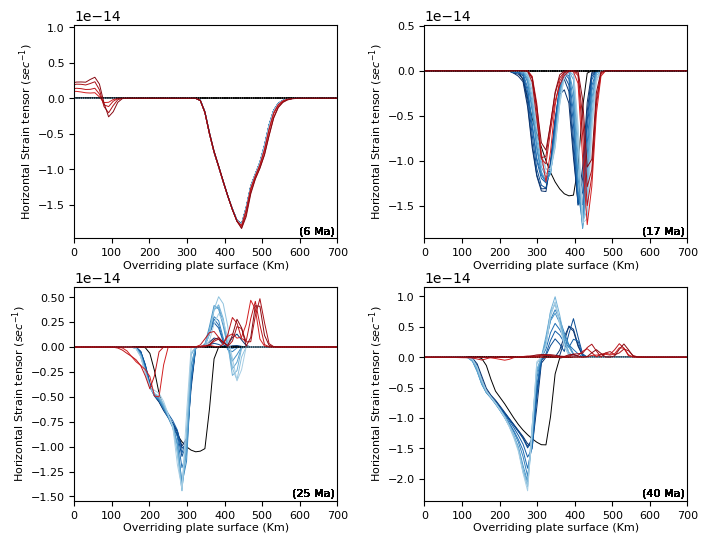

In [61]:
from matplotlib.ticker import ScalarFormatter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.offsetbox import AnchoredText
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
%matplotlib
fig, axs = pyplot.subplots(2,2,figsize=figsize)#,sharey=True)

positions=[(0,0),(0,1),(1,0),(1,1)]

counter=0
for thickness in thicknesses:
    if thickness==0:
        colour='black'
    else:
        colour=ColorsPlots[counter]
    plotCounter=0
    for time in time_stages:
        currentPos=positions[plotCounter]
        seed=axs[currentPos[0]][currentPos[1]]
        
        #xs,stress=loadParaviewData(dirr,time,0.5,thickness,"X_coord"),
        #loadParaviewData(dirr,time,0.5,thickness,"Dev_stress_x")
    
#         xs,strain=(loadParaviewData(dirr,time,0.5,thickness,"X_coord"),
#         loadParaviewData(dirr,time,0.5,thickness,"Dev_strain_x"))
        
        data=X_Stress_strain_calculator(DataDir,Model,thickness,time,0.,saveDir)
        xs=data[:,2]
        strain=data[:,1]
        
        seed.plot(xs,strain,label='Thickness={0} Km'.format((eval(str(thickness)))),linewidth=0.7,color=colour)
        seed.set_ylabel(r"Horizontal Strain tensor ($sec^{-1}$)",labelpad=2,fontsize=8)
                 #seed.set_ylabel(r"$V_{OPD}$"+" (cm/yr)",labelpad=2,fontsize=8)
        #seed.legend(fontsize=int(6),fancybox=True,loc='best')
        seed.tick_params(axis = 'both', which = 'major', labelsize =8) 
        seed.set_xlim(0,700)
        Max=max(strain)
        Min=min(strain)
        #ax.set_xlim(1800,-1800)
        #ax.set_ylim(Min+1/1.3*Min,Max+1/1.3*Max)
        #ax.set_ylim(Min-1/5*Min,Max+1/10*Max)
        #Title from loadaed file
        #seed.set_title(names[plotCounter],loc='center')
        anchored_title=AnchoredText('({0} Ma)'.format(str(time)),loc='lower right',pad=0.1,borderpad=0.1,frameon=False,prop=dict(size=8))
        seed.add_artist(anchored_title)
        #pyplot.yscale('symlog')

        seed.set_xlabel("Overriding plate surface (Km)",labelpad=2,fontsize=8)
        seed.axhline(y=0, xmin=0, xmax=max(data[0])+max(data[0])/6.,color='black',linestyle='--',linewidth=0.3)
        
        plotCounter=plotCounter+1
    counter=counter+1
fig.tight_layout(pad=1.,h_pad=0.08,w_pad=1.4)
fig
#fig.tight_layout(pad=1.,h_pad=0.08,w_pad=0.4) #older for velocities
#pyplot.subplots_adjust(hspace=0)

In [62]:
saveDir="/home/jovyan/user_data/Re-submission/Dynamics-of-Arc-Continent-Collision/Raw_PDFs/"
fig.savefig(saveDir+'Fig_9_raw.pdf')

In [56]:
DataDir="/home/jovyan/user_data/Stress_strainRate_tensor/"
saveDir="/home/jovyan/user_data/Re-submission/Dynamics-of-Arc-Continent-Collision/Raw_PDFs/"
#DataDir="./ViscousDissIntegral_data"
def X_Stress_strain_saver_Thicknesses(DataDir,Model,thicknesses,depth,saveDir):
    #areaTypes=["whole","Lithosphere","Mantle"]
    for i in thicknesses:
        #counterType=0
        for k in range(0,55):
            
            data=getHorizontalprofile(Dirdata,Model,i,k,0.,-1800.,1800.,3,0)
            xs=(data[0].magnitude)
            Stress=(data[1].magnitude)
            Strain=(data[2].magnitude)*1e16 #In order to be able to save the data
            
            StrainStressdata=np.zeros(shape=(len(Stress),3)) 
            #print(X[1])
            #Assign to structure-containing array
            counter=0
            for stress,strain,x in zip(Stress,Strain,xs):
            #print(Stress)
                StrainStressdata[counter][0]=stress  #Assign X-coordinate - Horizontal distance
                StrainStressdata[counter][1]=strain #Asign Y-Coordinate -GPE
                StrainStressdata[counter][2]=x
                counter=counter+1
        #counterType=counterType+1
            #Save data to txt File (2D-array)
            filename=saveDir+"Stress_strainRate_tensor_{0}km_{1}Ma_surface.txt".format(str(i),str(k))
            print(filename)
            np.savetxt(filename, StrainStressdata, fmt='%f')
    return 0



In [ ]:

#Topography=calculateTopographyProfile(densitySurface,densityAir,gravity,Stress,thicknessAir)


In [ ]:
loadStrainStress Data(Dir,time_in_Ma,step,thickness,fieldKey):
    stepTime=time_in_Ma/step
    fileBase="Strain_rate_tensor-x-"
    fileBase2=str(thickness)+"km_"+str(int(stepTime))+".csv"
    
    Dir=Dir+str(thickness)+"km/"
    #print(Dir+fileBase+fileBase2)
    Data=np.genfromtxt(Dir+fileBase+fileBase2,delimiter=',',skip_header=1,dtype=float)
    
    if fieldKey=="Dev_stress_x":
        data=Data[:,1]
    elif fieldKey=="Dev_strain_x":
        data=Data[:,2]
    elif fieldKey=="X_coord":
        data=Data[:,3]

    return data